# 4.2 Predictive Models Using Artificial Neural Network

Besides using Tree Based Models, we shall use an Artificial Neural Network (ANN) to explore if we can increase the accuracy of destination predictions. ANN is used as it takes all inputs into consideration - Each individual input connects to a neuron and when receiving input, change its internal state (i.e. the activation) according to that input and an activation function, and produce output depending on the input and the activation.

[Illustration](https://en.wikipedia.org/wiki/Artificial_neural_network#/media/File:Colored_neural_network.svg) as follows:
[ANN]()

As a regression approach is used in for our Tree Based Model, a classification approach will be used in the ANN model. 

To adopt an ANN the following steps are carried out:
 
1. Form clusters of our destinations in our train set by rounding them to the fourth decimal place and geohashing them
2. Split our train and val in to X (Predictor variables) and y (outcome variables) respectively
3. Design and built our ANN model with Harversine distance as our custom loss function
4. Fit X_train, y_train, X_val, y_val into our ANN to train it
5. Plot Training and Validation Loss per epoch to determine how good our ANN is performing
6. Chose the best model and use it to predict on our test set

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_pickle('./Pickles/train')
val = pd.read_pickle('./Pickles/val')
test = pd.read_pickle('./Pickles/test')

### To cluster our end destinations, a two step approach is taken:

1. Extracting destinations coordinates in a pair. As latitudes and longitudes up to [4 decimals place have a precision of 11.132m](https://en.wikipedia.org/wiki/Decimal_degrees), points along the same street with be effectively grouped together.
2. After rounding, in order to further cluster coordinates into larger groups, coordinates are geohashed. 
    - Geohash encodes a geographic location into a short string of letters and digits. It is a hierarchical spatial data structure which subdivides space into buckets of grid shape, using hilbert space filling curves. [More information on Geohash](http://www.bigfastblog.com/geohash-intro)
    - [Geohash package used](https://pypi.python.org/pypi/geohash-hilbert)
    - Geohash precision of 17, using with base 4 (2bit) is chosen as it groups coordinates within (0.152703km x 0.152703km = 0.02km sq) together
    - After encoding, geohashes are decoded to get the centroid coordinates representing each cluster
 
    

In [3]:
taxi = pd.concat([train, val], axis=0) #joining back train and val dataset to cluster end points

In [4]:
taxi["DESTINATION"] = taxi["POLYLINE"].map(lambda x: x[-1])
taxi["DESTINATION_ROUNDED"] = taxi["DESTINATION"].map(lambda x : np.around(x,decimals=4))

In [5]:
import geohash_hilbert as ghh
hashi = []
for x in taxi["DESTINATION_ROUNDED"]:
    h = ghh.encode(x[0],x[1],precision=17, bits_per_char=2)
    hashi.append(h)
    
taxi["GEOHASH"] = pd.DataFrame(hashi)

In [9]:
taxi["DECODED"] = taxi["GEOHASH"].map(lambda x : ghh.decode(x, bits_per_char=2))

In [10]:
# getting the unique lat,long and converting them from tuples to lists
def clusters(df):
    decoded_unique = []
    for line in df["DECODED"].unique():
        decoded_unique.append(list(line))
    return np.array(decoded_unique)

# getting the unique lat,long (which is the unique clusters) and converting them from tuples to lists
clusters = clusters(taxi)

As ANNs are sensitive to larger numbers, even though ORIGIN_CALL & TAXI_ID are in int/float, it is best practise to encode them. This also speeds up convergence. 

In [11]:
from sklearn import preprocessing

#Getting total class labels for both ORIGIN_CALL & TAXI_ID
total_caller = pd.DataFrame(pd.concat([taxi["ORIGIN_CALL"], test["ORIGIN_CALL"]]))
total_taxi_id = pd.DataFrame(pd.concat([taxi["TAXI_ID"], test["TAXI_ID"]]))


#Fit total class labels for both ORIGIN_CALL & TAXI_ID
taxi_id_encoder = preprocessing.LabelEncoder().fit(total_taxi_id["TAXI_ID"])
origin_call_encoder = preprocessing.LabelEncoder().fit(total_caller["ORIGIN_CALL"])


#Transform accordingly for train val and test
taxi["TAXI_ID"] = taxi_id_encoder.transform(taxi["TAXI_ID"])
taxi["ORIGIN_CALL"] = origin_call_encoder.transform(taxi["ORIGIN_CALL"])
test["TAXI_ID"] = taxi_id_encoder.transform(test["TAXI_ID"])
test["ORIGIN_CALL"] = origin_call_encoder.transform(test["ORIGIN_CALL"])

Creating a metadata dict to store nunique values of each feature as this is required to be specified when building the ANN. 

In [12]:
#preparing a dictionary of unique counts of 
metadata = {'CALL_TYPE': taxi["CALL_TYPE"].nunique() +1,
            'TAXI_ID': total_taxi_id["TAXI_ID"].nunique() +1,
            'WEEK': taxi["WEEK"].nunique()+1,
            'DAY': taxi["DAY"].nunique()+1,
            'Q_HOUR': taxi["Q_HOUR"].nunique()+1,
            'CALLER_ID' : total_caller["ORIGIN_CALL"].nunique()+1
           }

print metadata

{'WEEK': 53, 'Q_HOUR': 97, 'CALLER_ID': 54396, 'TAXI_ID': 440, 'DAY': 8, 'CALL_TYPE': 4}


In [13]:
#clustering completed, data is split back into both train and val sets
train = taxi.iloc[:taxi.shape[0] - int(0.001 * taxi.shape[0]) + 1].reset_index(drop=True)
val = taxi.iloc[taxi.shape[0] - int(0.001 * taxi.shape[0]) + 1:].reset_index(drop=True)

Similar to our tree based models, unrequired features are dropped.

In [14]:
def drop_col(df):
    """
    Dropping columns where features have been extracted
    1. TRIP_ID is actually made up of both TAXI_ID and TIMESTAMP
    2. Extracted all date_time data  
    """
    return df.drop([ u'TRIP_ID', u'TIMESTAMP', u'POLYLINE', u'date_time', u'DISTANCE', u'DURATION', u'DESTINATION',
       u'DESTINATION_ROUNDED', u'GEOHASH', u'END_LAT', u'END_LONG'], axis = 1)

In [15]:
train = drop_col(train)
val = drop_col(val)
test.drop([ u'TRIP_ID', u'TIMESTAMP', u'POLYLINE', u'date_time', u'DISTANCE', u'DURATION'], axis = 1, inplace=True)

### Split our train and val in to X (Predictor variables) and y (outcome variables) 

In [16]:
def X_y_split(df):
    """
    Getting independent (X) and dependent (y) variables
    """
    X = df.drop(['DECODED'], axis = 1).reset_index(drop=True)
    y = df.loc[:,['DECODED']].reset_index(drop=True)
    return X, y

In [17]:
X_train, y_train = X_y_split(train)
X_val, y_val = X_y_split(val)

### Building ANN model with the following architecture:

[ANN_Archi]()

The architecture is fairly simple, a vanilla NN. Categorical features are inputted into an embedding layer (this is analogous to one hot encoding in other ML models). Continuous features are inutted into a dense layer (fully connected layer). One hidden layer with 500 neurons is used with Relu as the activation function. The output of the first layer is passed into a subsequent layer with a softmax activation to aggregate the probability of clusters, the highest probability will be chosen as the prediction in the output layer. The loss function used would be a custom loss function - the haversine distance. The ANN model will be striving to reduce the distance between the predicted and actual values of the validation set. In addition, the keras package do not take in pandas dataframes, therefore pre-processing of all inputs to numpy arrays (matrices and vectors) has to carried out.

In [19]:
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam, Adagrad
from keras import backend as K
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Reshape, concatenate, Activation, Dropout, Flatten, Reshape, Embedding, Input, merge, Merge
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

Using TensorFlow backend.


In [20]:
input0 = Input(shape=(1,),name='Q_HOUR_input')
print K.shape(input0)
q_hour = Embedding(metadata['Q_HOUR'], 10)(input0)
q_hour = Reshape((10,))(q_hour)
print K.shape(q_hour)

input1 = Input(shape=(1,),name='TAXI_ID_input')
print K.shape(input1)
taxi_id = Embedding(metadata['TAXI_ID'], 10)(input1)
taxi_id = Reshape((10,))(taxi_id)
print K.shape(taxi_id)

input2 = Input(shape=(1,),name='WEEK_input')
print K.shape(input2)
week = Embedding(metadata['WEEK'], 10)(input2)
week = Reshape((10,))(week)
print K.shape(week)

input3 = Input(shape=(1,),name='DAY_input')
print K.shape(input3)
day = Embedding(metadata['DAY'], 10)(input3)
day = Reshape((10,))(day)
print K.shape(day)

input4 = Input(shape=(1,),name='CALL_TYPE_input')
print K.shape(input4)
call_type = Embedding(metadata['CALL_TYPE'], 10)(input4)
call_type = Reshape((10,))(call_type)
print K.shape(call_type)

input5 = Input(shape=(1,),name='CALLER_ID_input')
print K.shape(input5)
caller_id = Embedding(metadata['CALLER_ID'], 10)(input5)
caller_id = Reshape((10,))(caller_id)
print K.shape(call_type)

input6 = Input(shape=(18,), name='coords_input')
print K.shape(input6)
coords = Dense(1,)(input6)
print K.shape(coords)

input7 = Input(shape=(1,), name='distance_input')
print K.shape(input7)
distance = Dense(1)(input7)
print K.shape(distance)

input8 = Input(shape=(1,), name='duration_input')
print K.shape(input8)
duration = Dense(1)(input8)
print K.shape(duration)

taxi_merge = concatenate([q_hour, taxi_id, week, day, call_type, caller_id, coords, distance, duration])
layer_1 = Dense(500, activation="relu")(taxi_merge)
layer_2 = Dense(len(clusters),activation='softmax')(layer_1)
cast_clusters = K.cast_to_floatx(clusters)
print(cast_clusters.shape)
def destination(probabilities):
    return tf.matmul(probabilities, cast_clusters)
output_layer = Activation(destination)(layer_2)
model = Model(inputs=[input0, input1, input2, input3, input4, input5, input6, input7, input8], outputs=output_layer, name='taxi')

def tf_haversine(latlon1, latlon2):
    """
    Tensorflow version of the Haversine function to calculate distances between two sets of points.
    """
    lat1 = latlon1[:, 0]
    lon1 = latlon1[:, 1]
    lat2 = latlon2[:, 0]
    lon2 = latlon2[:, 1]

    REarth = 6371
    lat = tf.abs(lat1 - lat2) * np.pi / 180
    lon = tf.abs(lon1 - lon2) * np.pi / 180
    lat1 = lat1 * np.pi / 180
    lat2 = lat2 * np.pi / 180
    a = tf.sin(lat / 2) * tf.sin(lat / 2) + tf.cos(lat1) * tf.cos(lat2) * tf.sin(lon / 2) * tf.sin(lon / 2)
    d = 2 * tf_atan2(tf.sqrt(a), tf.sqrt(1 - a))
    return REarth * d


def tf_atan2(y, x):
    """
    Tensorflow doesn't have an Atan2 function (at least not yet, see: https://github.com/tensorflow/tensorflow/issues/6095).
    So we define it here ourselves.
    """
    angle = tf.where(tf.greater(x,0.0), tf.atan(y/x), tf.zeros_like(x))
    angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.greater_equal(y,0.0)), tf.atan(y/x) + np.pi, angle)
    angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.less(y,0.0)), tf.atan(y/x) - np.pi, angle)
    angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.greater(y,0.0)), 0.5*np.pi * tf.ones_like(x), angle)
    angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.less(y,0.0)), -0.5*np.pi * tf.ones_like(x), angle)
    angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.equal(y,0.0)), np.nan * tf.zeros_like(x), angle)
    return angle

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipvalue=1.)
model.compile(loss=tf_haversine, optimizer=optimizer)

Tensor("Shape:0", shape=(2,), dtype=int32)
Tensor("Shape_1:0", shape=(2,), dtype=int32)
Tensor("Shape_2:0", shape=(2,), dtype=int32)
Tensor("Shape_3:0", shape=(2,), dtype=int32)
Tensor("Shape_4:0", shape=(2,), dtype=int32)
Tensor("Shape_5:0", shape=(2,), dtype=int32)
Tensor("Shape_6:0", shape=(2,), dtype=int32)
Tensor("Shape_7:0", shape=(2,), dtype=int32)
Tensor("Shape_8:0", shape=(2,), dtype=int32)
Tensor("Shape_9:0", shape=(2,), dtype=int32)
Tensor("Shape_10:0", shape=(2,), dtype=int32)
Tensor("Shape_11:0", shape=(2,), dtype=int32)
Tensor("Shape_12:0", shape=(2,), dtype=int32)
Tensor("Shape_13:0", shape=(2,), dtype=int32)
Tensor("Shape_14:0", shape=(2,), dtype=int32)
Tensor("Shape_15:0", shape=(2,), dtype=int32)
Tensor("Shape_16:0", shape=(2,), dtype=int32)
Tensor("Shape_17:0", shape=(2,), dtype=int32)
(6029, 2)


In [22]:
def get_coordinates(df):
    coords = pd.concat([df['START_LAT'], df['START_LONG'], 
                        df['LAT_2'], df['LONG_2'], 
                        df['LAT_3'], df['LONG_3'], 
                        df['LAT_4'], df['LONG_4'], 
                        df['LAT_5'], df['LONG_5'],
                        df['LAT_5_last'], df['LONG_5_last'],
                        df['LAT_4_last'], df['LONG_4_last'], 
                        df['LAT_3_last'], df['LONG_3_last'], 
                        df['LAT_2_last'], df['LONG_2_last']], axis=1)
    return coords

In [23]:
# total_coordinates = get_coordinates(taxi)
X_train_coordinates = pd.DataFrame(get_coordinates(X_train))
X_val_coordinates = pd.DataFrame(get_coordinates(X_val))
total_coordinates = pd.concat([X_train_coordinates, X_val_coordinates], axis=0)

In [24]:
from sklearn.preprocessing import StandardScaler

coords_scaler = StandardScaler().fit(total_coordinates)
X_train_coordinates = coords_scaler.transform(X_train_coordinates)
X_val_coordinates = coords_scaler.transform(X_val_coordinates)

In [25]:
#preparing X, converting dataframe series into np arrays and also reshaping them to fit into the model
def X_prep(df,coords):
    X = []
    Q_HOUR = df["Q_HOUR"].as_matrix()
    Q_HOUR = Q_HOUR.reshape(df.shape[0],1)
    X.append(Q_HOUR)
    
    TAXI_ID = df["TAXI_ID"].as_matrix()
    TAXI_ID = TAXI_ID.reshape(df.shape[0],1)
    X.append(TAXI_ID)
    
    WEEK = df["WEEK"].as_matrix()
    WEEK = WEEK.reshape(df.shape[0],1)
    X.append(WEEK)
    
    DAY = df["DAY"].as_matrix()
    DAY = DAY.reshape(df.shape[0],1)
    X.append(DAY)
    
    CALLER_ID = df["ORIGIN_CALL"].as_matrix()
    CALLER_ID = CALLER_ID.reshape(df.shape[0],1)
    X.append(CALLER_ID)
    
    CALL_TYPE = df["CALL_TYPE"].as_matrix()
    CALL_TYPE = CALL_TYPE.reshape(df.shape[0],1)
    X.append(CALL_TYPE)
    
    COORDS = coords
    X.append(COORDS)
    
    DIS = df["DISTANCE_LOG"].as_matrix()
    DIS = DIS.reshape(df.shape[0],1)
    X.append(DIS)
    
    DUR = df["DURATION_LOG"].as_matrix()
    DUR = DUR.reshape(df.shape[0],1)
    X.append(DUR)
    
    return X

X_train_array = X_prep(X_train, X_train_coordinates)
X_val_array = X_prep(X_val, X_val_coordinates)

In [26]:
#converting lat,longs in tuples into list
def y_labels(df):
    decoded = []
    for line in df["DECODED"]:
        decoded.append(list(line))
    return np.array(decoded)

#y_labels in np array
y_train_array = y_labels(y_train)
y_val_array = y_labels(y_val)

In [27]:
callbacks = []
# Save the model's intermediary weights to disk after each epoch
file_path = "./taxi-{epoch:03d}-{val_loss:.4f}.hdf5"
callbacks.append(ModelCheckpoint(file_path, monitor='val_loss', mode='min', save_weights_only=True, verbose=1))

history = model.fit(X_train_array, y_train_array, batch_size=200,
                    callbacks=callbacks,validation_data=(X_val_array, y_val_array),epochs=50)

Train on 1580976 samples, validate on 1581 samples
Epoch 1/50
1580976/1580976 [==============================] - 96s 60us/step - loss: 1.3918 - val_loss: 3.5151
Epoch 2/50
1580976/1580976 [==============================] - 95s 60us/step - loss: 1.2237 - val_loss: 3.4535
Epoch 3/50
1580976/1580976 [==============================] - 94s 60us/step - loss: 1.1699 - val_loss: 3.5151
Epoch 4/50
1580976/1580976 [==============================] - 96s 60us/step - loss: 1.1363 - val_loss: 3.4942
Epoch 5/50
1580976/1580976 [==============================] - 95s 60us/step - loss: 1.1197 - val_loss: 3.5090
Epoch 6/50
1580976/1580976 [==============================] - 95s 60us/step - loss: 1.1071 - val_loss: 3.4991
Epoch 7/50
1580976/1580976 [==============================] - 96s 60us/step - loss: 1.1030 - val_loss: 3.5443
Epoch 8/50
1580976/1580976 [==============================] - 96s 60us/step - loss: 1.0906 - val_loss: 3.5103
Epoch 9/50
1580976/1580976 [==============================] - 96s 61u

In [40]:
model.save('./ann_50epcoh.h5')

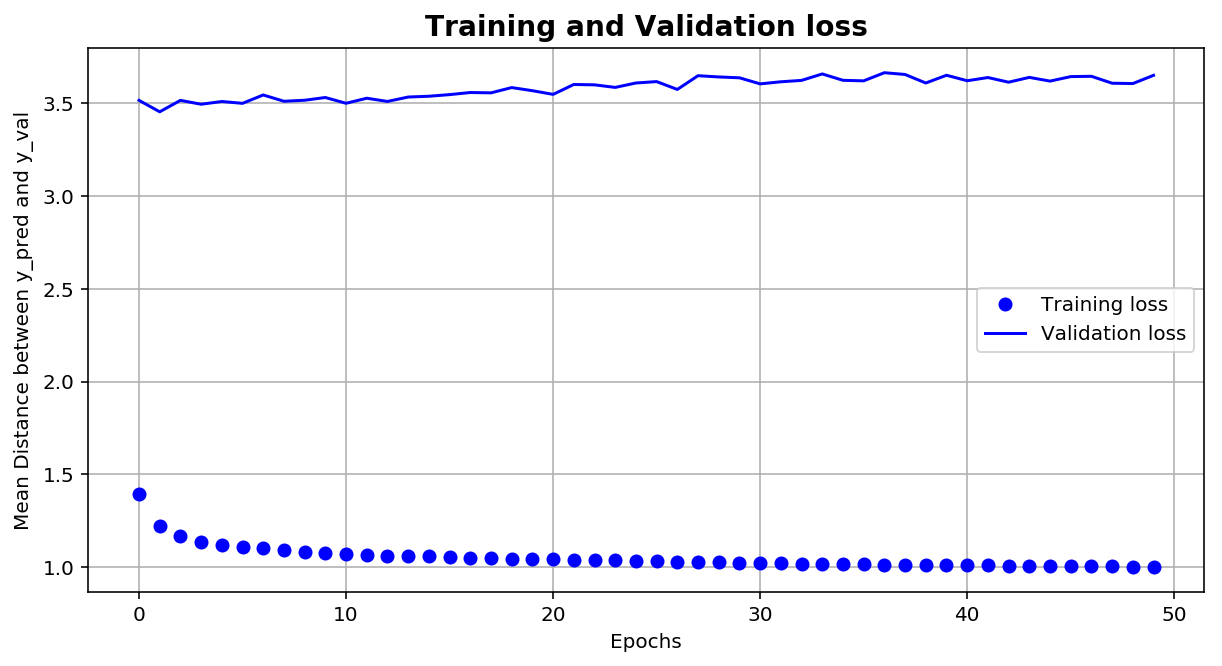

In [32]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
h = history.history

loss = h['loss']
val_loss = h['val_loss']

epochs = range(len(loss))

f,ax = plt.subplots(figsize=(10,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylabel('Mean Distance between y_pred and y_val')
plt.xlabel('Epochs')
plt.title('Training and Validation loss', fontsize=14, fontweight='bold')
plt.grid()
plt.legend()
plt.show()

From the plot above, the training loss keeps decreasing, whereas the valiadation loss is rather consistent with minimal fluctuations. After epoch 20, the validation loss seems to have increased slightly, whereas the training continues to decrease. This shows that the model might be overfitting towards the training set. 

### Prep test set to fit in ANN model

In [33]:
test_coordinates = pd.DataFrame(get_coordinates(test))
test_coordinates = coords_scaler.transform(test_coordinates)

In [34]:
test.columns

Index([u'CALL_TYPE', u'ORIGIN_CALL', u'TAXI_ID', u'START_LAT', u'START_LONG',
       u'WEEK', u'DAY', u'Q_HOUR', u'DURATION_LOG', u'DISTANCE_LOG', u'LAT_2',
       u'LAT_3', u'LAT_4', u'LAT_5', u'LONG_2', u'LONG_3', u'LONG_4',
       u'LONG_5', u'LAT_2_last', u'LAT_3_last', u'LAT_4_last', u'LAT_5_last',
       u'LONG_2_last', u'LONG_3_last', u'LONG_4_last', u'LONG_5_last'],
      dtype='object')

In [35]:
test_array = X_prep(test, test_coordinates)

In [37]:
test_pred = model.predict(test_array)
test_pred_df = pd.DataFrame(data = test_pred, columns=["LATITUDE", "LONGITUDE"])

In [38]:
test_pred_df.head()

,LATITUDE,LONGITUDE
0,41.148949,-8.584395
1,41.159428,-8.601141
2,41.166698,-8.574886
3,41.147053,-8.615635
4,41.153099,-8.607381


In [39]:
test_pred_df.to_csv('./nn_50_epoch.csv')

Public Score: 3.02832 #115/381  
Private Score: 3.13960 #259/381

Conclusion: 

Prediction of destinations up to 3km accuracy is possible with:
* Date & Time
* Location data in the form of coordinates

However, by adopting a classification model, due to the nature that the coordinates are extremely granular and there are places which the majority of the the public do not usually go, i.e farms in the outskirts of the city vs the city centre. The amount of points to form a cluster is extremely important to avoid a multivariate imbalance issue. However, it is extremely hard to determine the right amount of points required without domain expertise. Therefore, I strongly suggest using a regression model is more suited to predict destinations of trips. 

Further work:
- Use a regression ANN model to predict destinations
- Use of deep learning models such as Sequence to Sequence Recursive Neural Nets to be able to the path taken up to the destination 
- Explore other predictive models such as Hidden Markov Model or Karman filters to see if they are suitable to predict destinations
- Include more features, such as holiday and weather information to help improve the predictions